
# Amazon Clothing Sales 2025 — EDA Notebook (DS/AI 12)

**Scope:** From **Initial Data Exploration & Cleaning** to **Visualization Expectations**.  
**Libraries:** `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn` (import only), `fuzzywuzzy`.  
**Note:** Plots are produced with Matplotlib. No machine learning is used.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install fuzzywuzzy

# Plot config
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Display config
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A. Initial Data Exploration & Cleaning

In [ ]:

# Load
df = pd.read_csv("/content/drive/MyDrive/_Amazon_Clothing_Sales_2025 DS12  - Amazon_Clothing_Sales_2025 (1).csv")

# Snapshot
print("Shape:", df.shape)
display(df.head(3))
display(df.tail(3))

# Basic info
display(df.dtypes)


Shape: (25000, 19)


,order_id,customer_id,product_id,product_name,main_category,sub_category,brand,price,quantity,discount_percent,final_price,payment_method,review_rating,order_date,delivery_days,is_returned,region,customer_age_group,device_type
0,#HLWTRIGAJB0RFL,A86556872001,6Q3V14RXRF,Huggies Rompers,baby,Rompers,Huggies,118.62,1,10,106.76,PayPal,3,2024-09-10,5.0,0,Midwest,25-34,Mobile
1,#9LMWG6T6H0IPE0,0A9218115AAA,33MRMEM3WN,Gerber Blankets,Baby,Blankets,Gerber,26.84,1,15,22.81,Gift Card,2,2025-06-25,8.0,0,West,25-34,Mobile
2,#Q6J5C5621SSE5V,8A5A09200074,E674NZH16V,Fossil Jeans,Men,Jeans,Fossil,219.38,2,25,329.07,Gift Card,4,2025-01-08,5.0,0,Northeast,35-44,Mobile


,order_id,customer_id,product_id,product_name,main_category,sub_category,brand,price,quantity,discount_percent,final_price,payment_method,review_rating,order_date,delivery_days,is_returned,region,customer_age_group,device_type
24997,#DU71O3MXXZVT1L,440170188725,590V1TJQGC,Levi's Jeans,Men,Jeans,Levi's,130.87,2,20,209.39,Credit Card,1,2025-01-09,8.0,0,Midwest,25-34,App
24998,#YHNPOPWUO47P0G,A8A224901522,QNPGMXCYIS,The Peanutshell Booties,Baby,Booti3s,The Peanutshell,172.17,1,15,146.34,Cash on Delivery,4,2024-10-23,4.0,0,Northeast,25-34,Desktop
24999,#ESF9EL1PBJ19OS,437139608515,TKVZYTQKPQ,Nike Jackets,Men,Jackets,Nike,60.71,2,25,91.06,PayPal,5,2024-09-20,5.0,0,Midwest,NaN,Desktop


,0
order_id,object
customer_id,object
product_id,object
product_name,object
main_category,object
sub_category,object
brand,object
price,float64
quantity,int64
discount_percent,int64


In [ ]:

# Ensure expected columns exist (from project brief)
expected_cols = [
    "order_id","customer_id","product_id","product_name","main_category","sub_category",
    "brand","price","quantity","discount_percent","final_price","payment_method",
    "review_rating","order_date","delivery_days","is_returned","region",
    "customer_age_group","device_type"
]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing expected columns:", missing)

# Convert order_date to datetime, coerce errors
df["order_date"] = pd.to_datetime(df.get("order_date", pd.NaT), errors="coerce")

# Ensure numeric types where appropriate
for c in ["price","quantity","discount_percent","final_price","review_rating","delivery_days","is_returned"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

display(df.dtypes)


Missing expected columns: []


,0
order_id,object
customer_id,object
product_id,object
product_name,object
main_category,object
sub_category,object
brand,object
price,float64
quantity,int64
discount_percent,int64


### Missing Values

In [ ]:

# Percentage missing per column
missing_summary = df.isna().mean().sort_values(ascending=False).to_frame("missing_pct")
display((missing_summary*100).round(2))

# Simple missing strategy (example):
# - If 'quantity' missing => set to 1 (common default for retail orders)
# - If 'discount_percent' missing => set to 0
# - If 'delivery_days' negative or missing => set to NaN
# - Leave review_rating as is (we'll describe later)
if "quantity" in df.columns:
    df["quantity"] = df["quantity"].fillna(1).clip(lower=1)
if "discount_percent" in df.columns:
    df["discount_percent"] = df["discount_percent"].fillna(0).clip(lower=0)
if "delivery_days" in df.columns:
    df.loc[df["delivery_days"].isna() | (df["delivery_days"] < 0), "delivery_days"] = np.nan

# For 'price' / 'final_price', we won't impute blindly; keep for quality checks


,missing_pct
device_type,5.0
customer_age_group,5.0
brand,5.0
region,5.0
payment_method,5.0
delivery_days,1.0
price,1.0
product_id,0.0
customer_id,0.0
order_id,0.0


### Duplicates & Integrity Checks

In [ ]:

# Duplicates by full row
dup_count = df.duplicated().sum()
print("Exact duplicate rows:", dup_count)

# If duplicates exist, drop them but keep first occurrence
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)

# A looser duplicate check by 'order_id' + 'product_id' (if both exist)
if {"order_id","product_id"}.issubset(df.columns):
    key_dups = df.duplicated(subset=["order_id","product_id"]).sum()
    print("Duplicates by (order_id, product_id):", key_dups)
    if key_dups > 0:
        df = df.drop_duplicates(subset=["order_id","product_id"]).reset_index(drop=True)

# Consistency check: price, discount_percent, final_price ~ quantity * price * (1 - discount%)
if {"price","discount_percent","quantity","final_price"}.issubset(df.columns):
    theoretical_total = df["price"] * df["quantity"] * (1 - df["discount_percent"]/100.0)
    df["final_price_calc"] = theoretical_total
    df["final_price_diff"] = df["final_price"] - df["final_price_calc"]
    # Mark rows where the absolute difference is > small tolerance (currency rounding)
    tol = 0.05  # 5 cents
    df["price_mismatch_flag"] = df["final_price_diff"].abs() > tol
    print("Price mismatch rows:", int(df["price_mismatch_flag"].sum()))
    display(df.loc[df["price_mismatch_flag"]].head(5))


Exact duplicate rows: 0
Duplicates by (order_id, product_id): 0
Price mismatch rows: 0


,order_id,customer_id,product_id,product_name,main_category,sub_category,brand,price,quantity,discount_percent,final_price,payment_method,review_rating,order_date,delivery_days,is_returned,region,customer_age_group,device_type,final_price_calc,final_price_diff,price_mismatch_flag


### Outliers (IQR-based)

In [ ]:

def iqr_outlier_bounds(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k*iqr
    high = q3 + k*iqr
    return low, high

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_report = []
for c in numeric_cols:
    if df[c].notna().sum() == 0:
        continue
    low, high = iqr_outlier_bounds(df[c].dropna())
    outliers = ((df[c] < low) | (df[c] > high)).sum()
    outlier_report.append((c, int(outliers), float(low), float(high)))

outlier_df = pd.DataFrame(outlier_report, columns=["column","outliers","low_bound","high_bound"]).sort_values("outliers", ascending=False)
display(outlier_df.head(10))

# Example treatment: cap extreme outliers (winsorize) for a few key columns
for c in ["price","final_price","discount_percent","delivery_days","quantity"]:
    if c in df.columns:
        low, high = iqr_outlier_bounds(df[c].dropna(), k=1.5)
        df[c] = df[c].clip(lower=low, upper=high)


,column,outliers,low_bound,high_bound
6,is_returned,2461,0.000000,0.000000
4,review_rating,1254,1.500000,5.500000
3,final_price,174,-307.228750,822.041250
7,final_price_calc,171,-307.336125,822.676875
0,price,0,-138.486250,449.503750
1,quantity,0,-2.000000,6.000000
2,discount_percent,0,-17.500000,42.500000
5,delivery_days,0,-3.000000,13.000000
8,final_price_diff,0,-0.008000,0.008000


### Merge Similar Contents (Case & Fuzzy)

In [ ]:
# Helper to tidy strings
def clean_str(x):
    if pd.isna(x):
        return x
    x = str(x).strip()
    x = x.replace("’","'").replace("“","\"").replace("”","\"")
    return x

for c in ["main_category","sub_category","brand","payment_method","region","customer_age_group","device_type"]:
    if c in df.columns:
        df[c] = df[c].map(clean_str)

# Canonical categories for main_category
canonical_main = ["Men","Women","Kids","Baby"]

# Import process and fuzz from fuzzywuzzy
from fuzzywuzzy import process, fuzz

def fuzzy_canonicalize(value, canon_list, threshold=85):
    if pd.isna(value):
        return value
    match, score = process.extractOne(str(value), canon_list, scorer=fuzz.token_sort_ratio)
    return match if score >= threshold else value

if "main_category" in df.columns:
    # First simple case normalization to Title
    df["main_category"] = df["main_category"].str.title()
    # Then fuzzy match to canonical
    df["main_category"] = df["main_category"].apply(lambda v: fuzzy_canonicalize(v, canonical_main, threshold=80))

# Example: merge near-duplicate sub_category or brand entries by fuzzy mapping to top N frequent labels
def build_fuzzy_map(series, top_n=50, threshold=90):
    s = series.dropna().astype(str).str.strip()
    if s.empty:
        return {}
    top_labels = s.value_counts().head(top_n).index.tolist()
    mapping = {}
    for v in s.unique():
        m, sc = process.extractOne(v, top_labels, scorer=fuzz.token_sort_ratio)
        if sc >= threshold:
            mapping[v] = m
    return mapping

for c in ["sub_category","brand"]:
    if c in df.columns:
        fmap = build_fuzzy_map(df[c], top_n=50, threshold=92)
        df[c] = df[c].replace(fmap)

# Example check for the requested case ('men' and 'Men' => 'Men')
if "main_category" in df.columns:
    print("Main category unique (sample):", sorted(df["main_category"].dropna().unique())[:20])

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Main category unique (sample): ['Baby', 'Kids', 'Men', 'Women']


### Feature Engineering

In [ ]:

if "order_date" in df.columns:
    df["order_year"] = df["order_date"].dt.year
    df["order_month"] = df["order_date"].dt.to_period("M").astype(str)
    df["order_weekday"] = df["order_date"].dt.day_name()

if {"price","discount_percent"}.issubset(df.columns):
    df["discount_amount"] = (df["price"] * df["discount_percent"] / 100.0)

if {"final_price","quantity"}.issubset(df.columns):
    df["unit_price"] = df["final_price"] / df["quantity"]
    # Protect against inf
    df["unit_price"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Delivery speed flag
if "delivery_days" in df.columns:
    # Define threshold (<=3 days is "fast" as an example; you can adjust)
    df["delivery_speed"] = np.where(df["delivery_days"] <= 3, "Fast", "Slow")

# Customer-level aggregates
if {"customer_id","final_price","review_rating","is_returned"}.issubset(df.columns):
    cust_agg = df.groupby("customer_id").agg(
        total_spend=("final_price","sum"),
        total_orders=("order_id","nunique"),
        avg_rating=("review_rating","mean"),
        return_rate=("is_returned","mean")
    ).reset_index()
    # Merge back
    df = df.merge(cust_agg, on="customer_id", how="left")
    display(cust_agg.head())


/tmp/ipython-input-449522158.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["unit_price"].replace([np.inf, -np.inf], np.nan, inplace=True)


,customer_id,total_spend,total_orders,avg_rating,return_rate
0,0000A5486A60,565.98,1,2.0,0.0
1,000128A482A9,343.10,1,3.0,0.0
2,0006310A3377,203.02,1,5.0,0.0
3,00069A393862,541.82,1,3.0,0.0
4,00070A643221,86.88,1,4.0,0.0


In [ ]:

CLEAN_PATH = "/content/drive/MyDrive/amazon_clothing_cleaned.csv"
df.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned data to:", CLEAN_PATH)


Saved cleaned data to: /content/drive/MyDrive/amazon_clothing_cleaned.csv


## B. Univariate Analysis

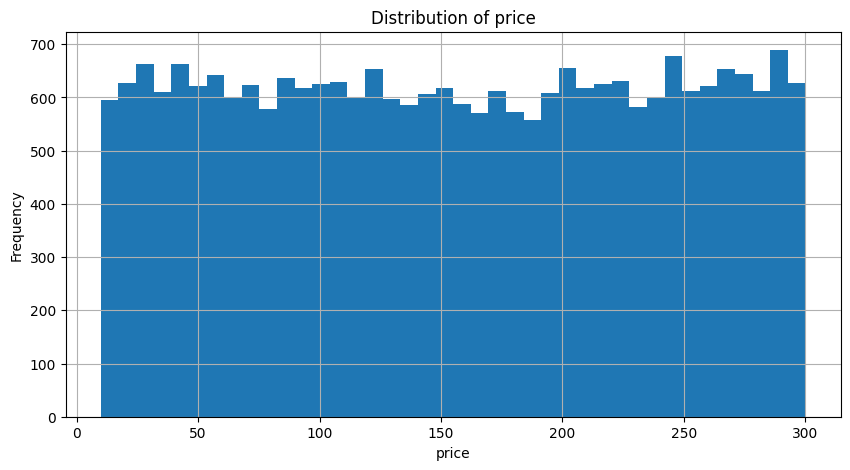

Takeaway: price shows central tendency around 154.805


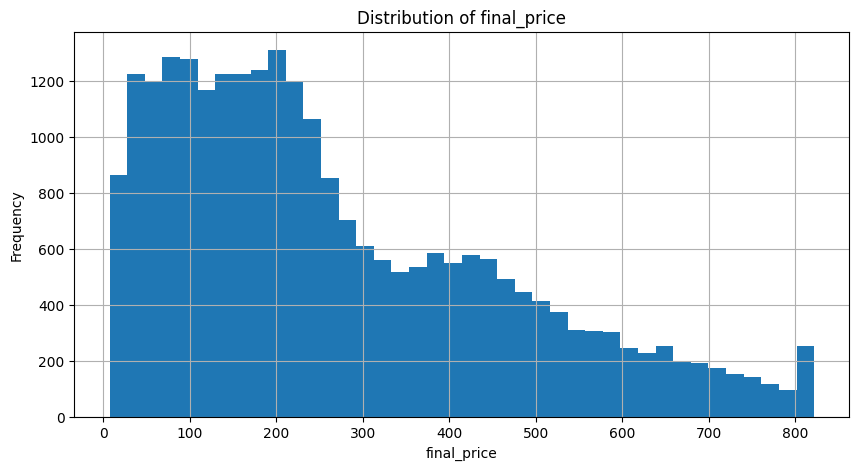

Takeaway: final_price shows central tendency around 219.41


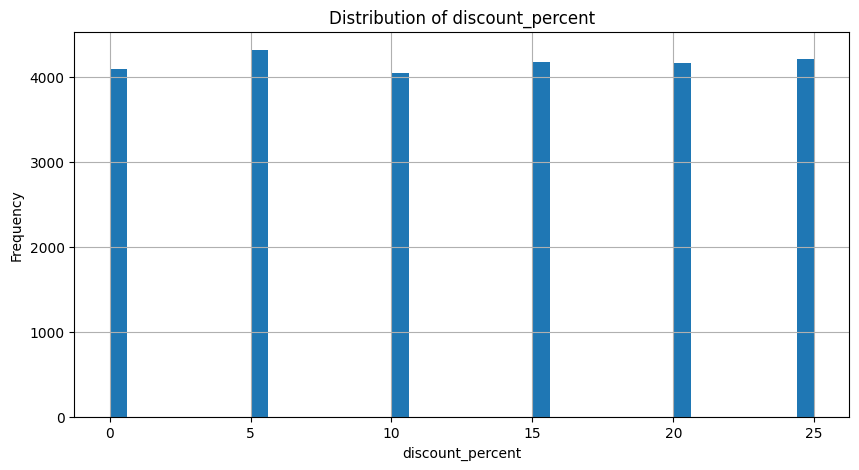

Takeaway: discount_percent shows central tendency around 15.0


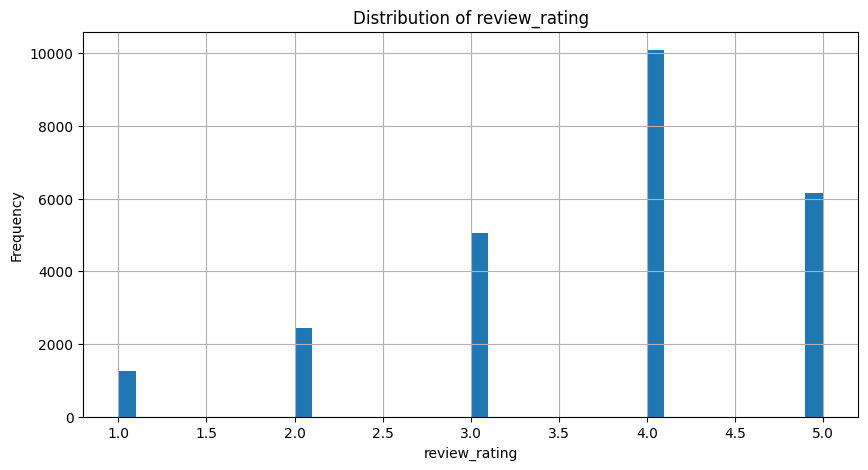

Takeaway: review_rating shows central tendency around 4.0


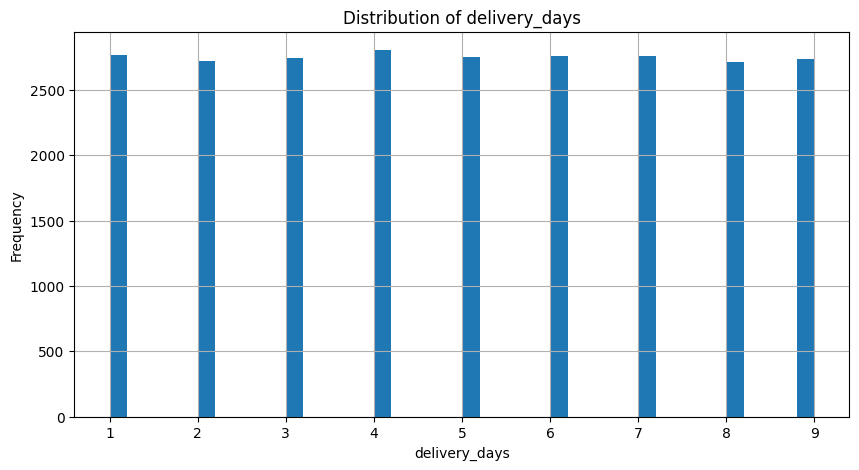

Takeaway: delivery_days shows central tendency around 5.0


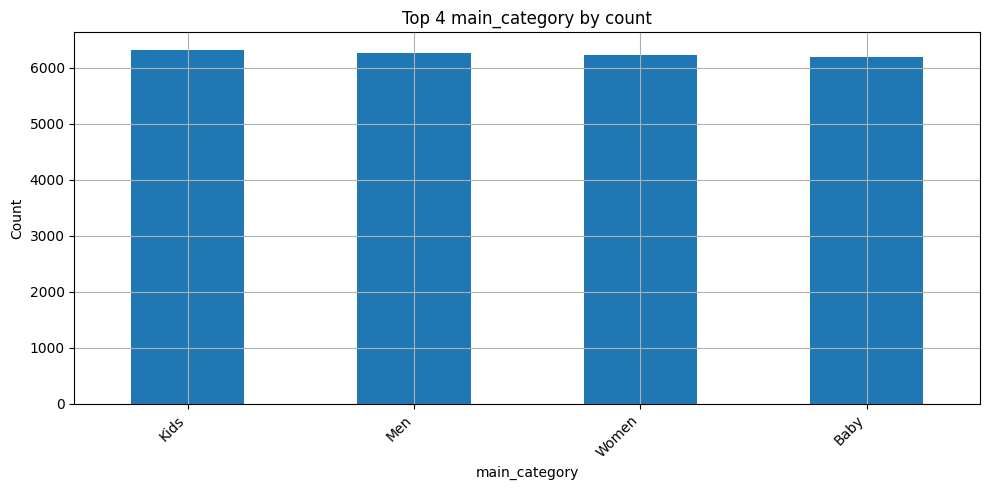

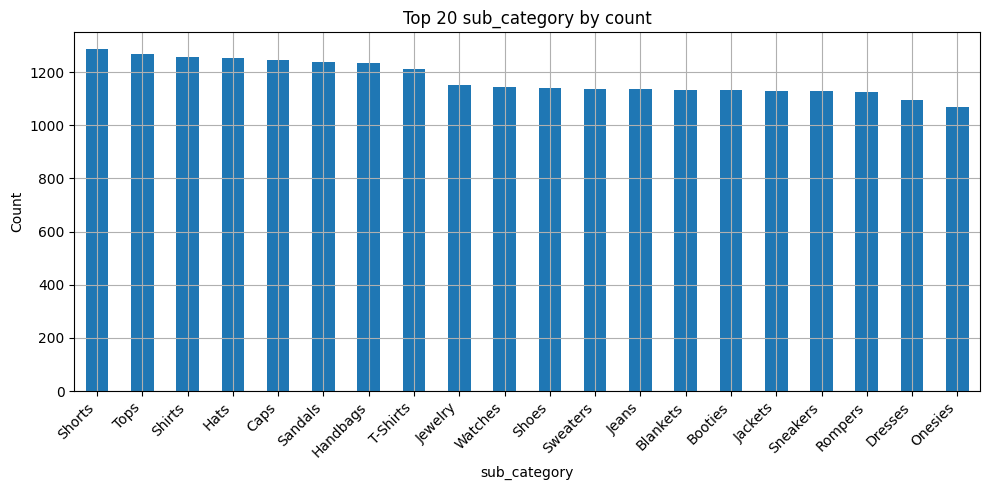

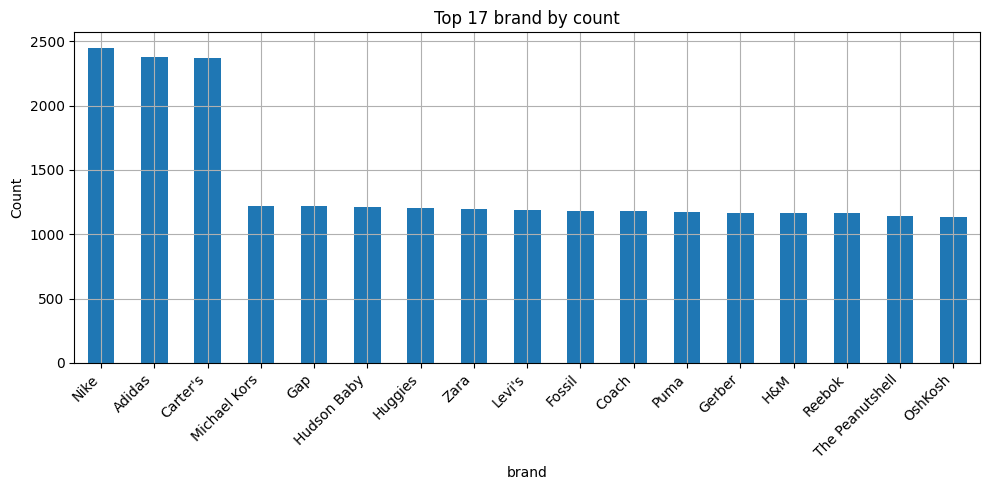

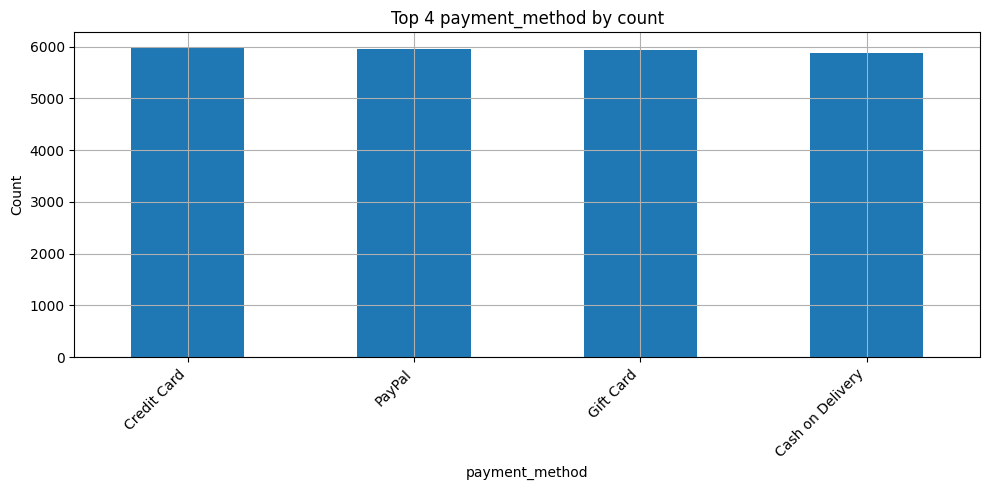

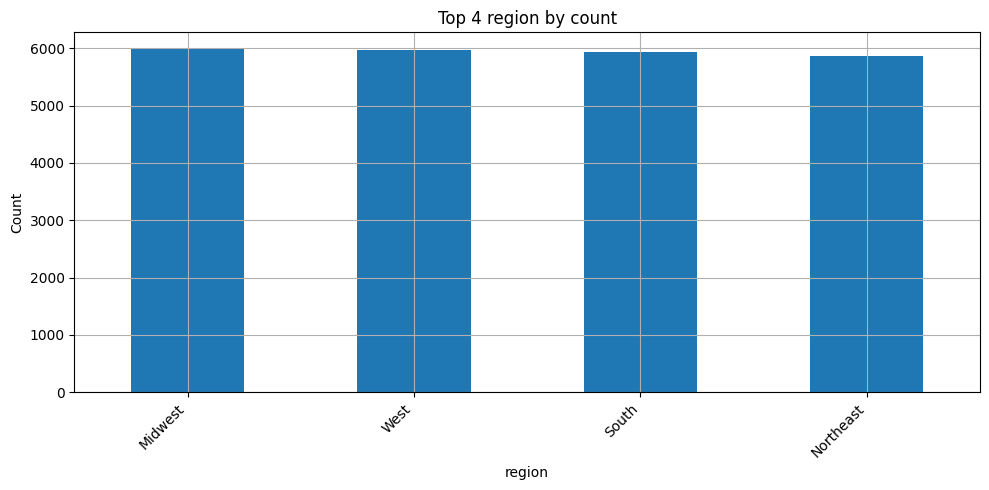

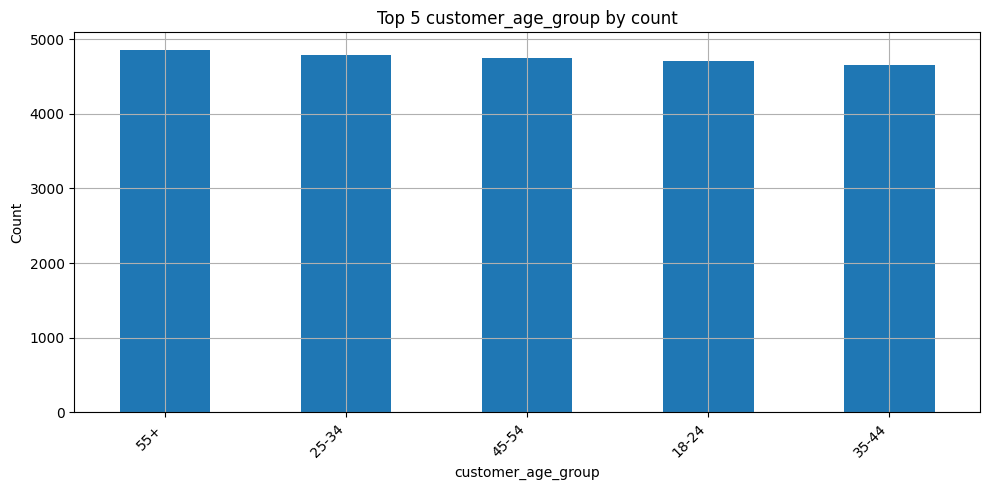

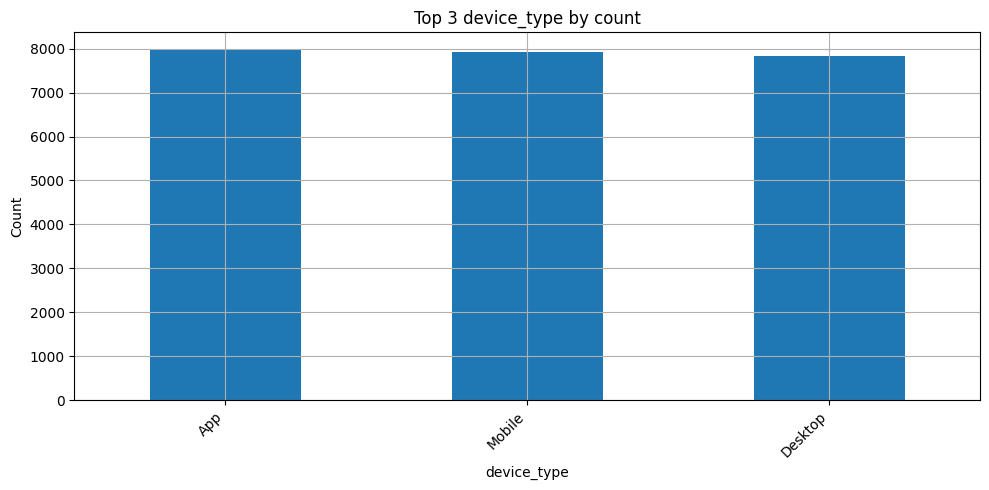

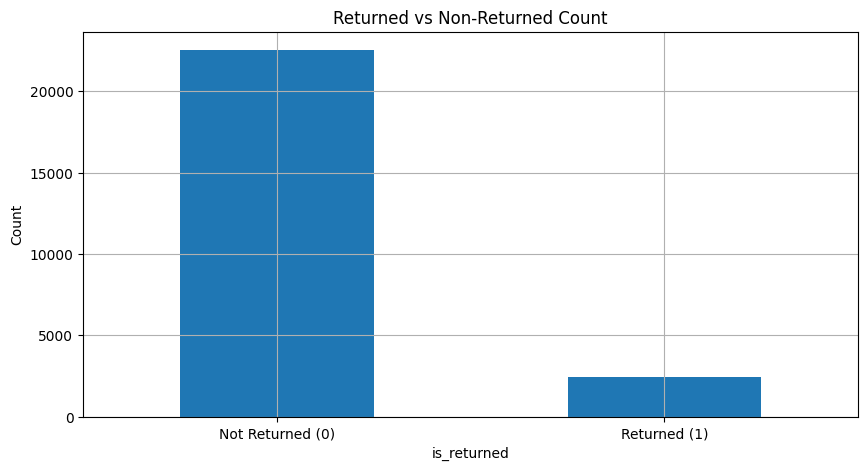

Takeaway: Return proportion: 9.84 %


In [ ]:

# Numeric distributions
num_cols = ["price","final_price","discount_percent","review_rating","delivery_days"]
for c in num_cols:
    if c in df.columns:
        plt.figure()
        plt.hist(df[c].dropna(), bins=40)
        plt.title(f"Distribution of {c}")
        plt.xlabel(c)
        plt.ylabel("Frequency")
        plt.show()
        print(f"Takeaway: {c} shows central tendency around", np.nanmedian(df[c]))

# Categorical counts
cat_cols = ["main_category","sub_category","brand","payment_method","region","customer_age_group","device_type"]
for c in cat_cols:
    if c in df.columns:
        counts = df[c].value_counts().head(20)
        plt.figure()
        counts.plot(kind="bar")
        plt.title(f"Top {min(20, len(counts))} {c} by count")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Returned vs non-returned proportion
if "is_returned" in df.columns:
    ret_counts = df["is_returned"].value_counts().sort_index()
    labels = ["Not Returned (0)","Returned (1)"]
    plt.figure()
    ret_counts.plot(kind="bar")
    plt.title("Returned vs Non-Returned Count")
    plt.xlabel("is_returned")
    plt.ylabel("Count")
    plt.xticks(ticks=[0,1], labels=labels, rotation=0)
    plt.show()
    print("Takeaway: Return proportion:", (df["is_returned"].mean()*100).round(2), "%")


## C. Bivariate & Multivariate Analysis

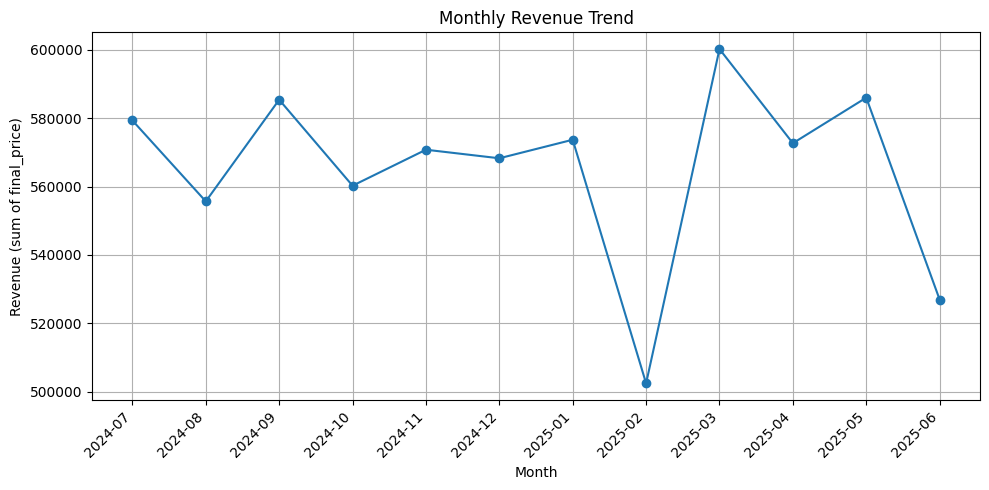

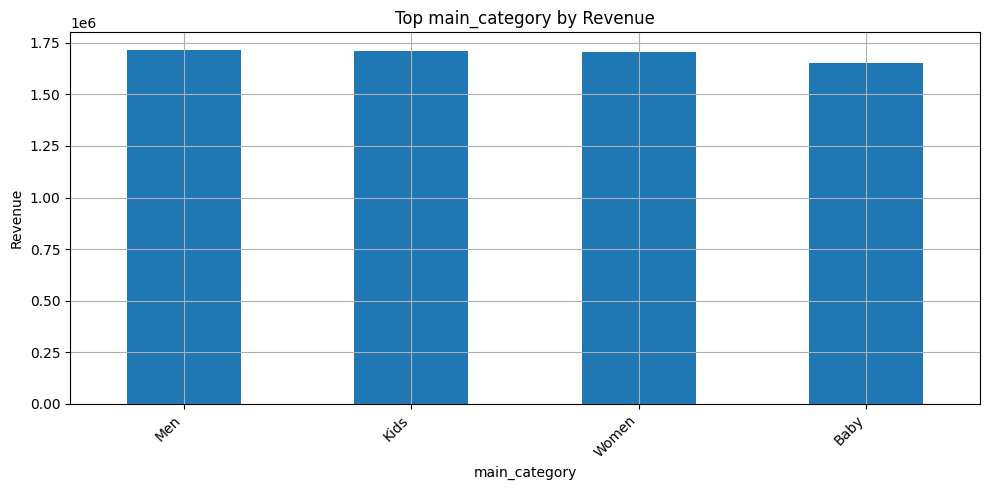

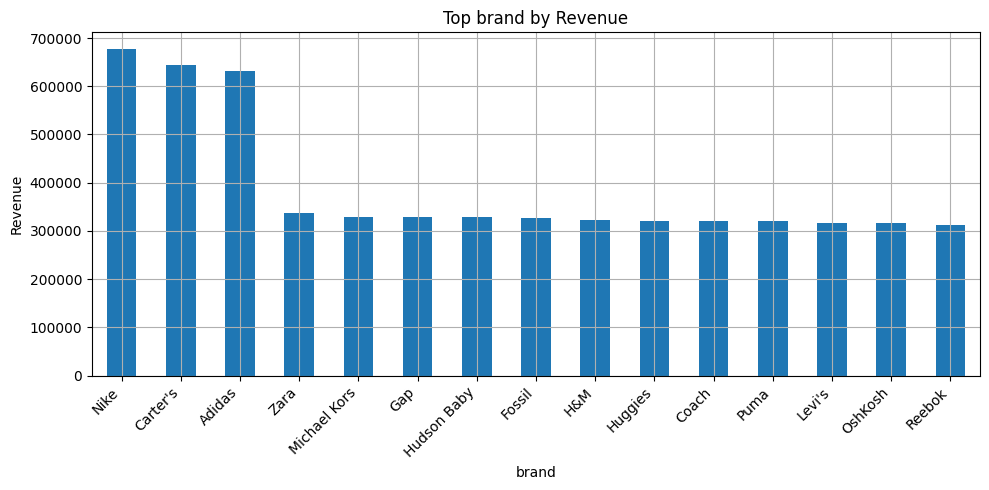

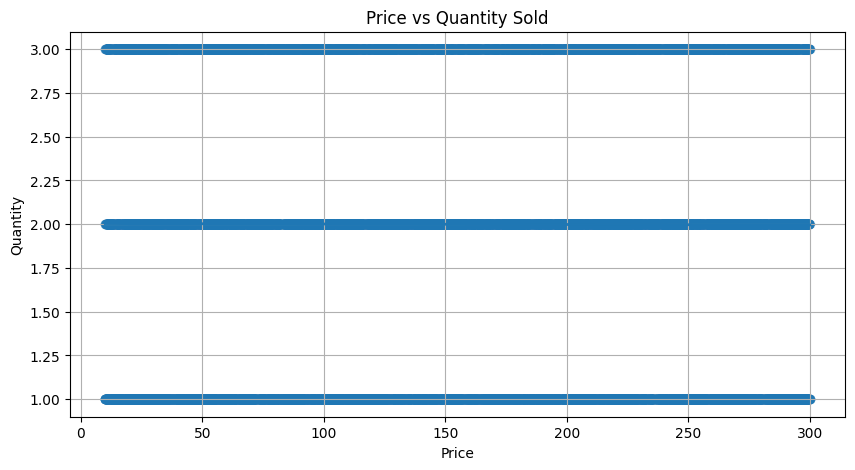

Takeaway: Negative slope suggests higher prices may reduce quantity (verify with data).


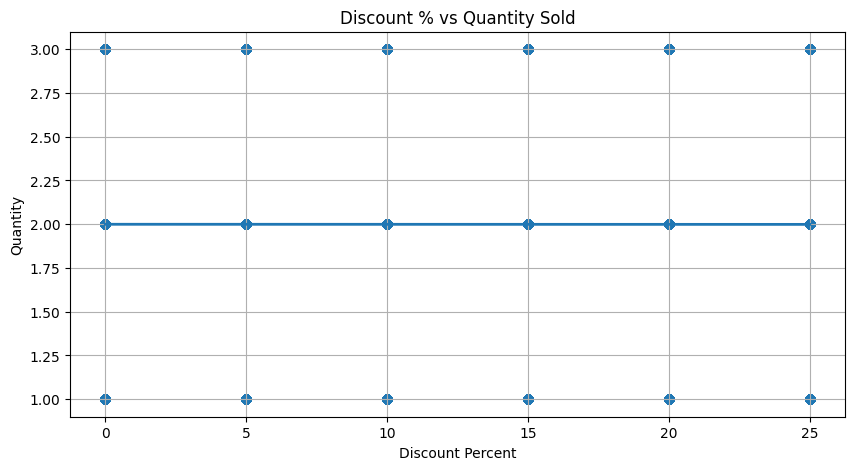

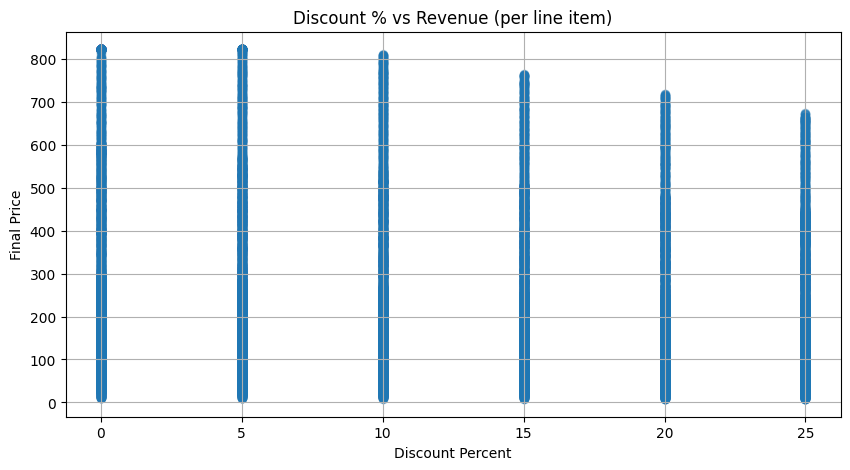

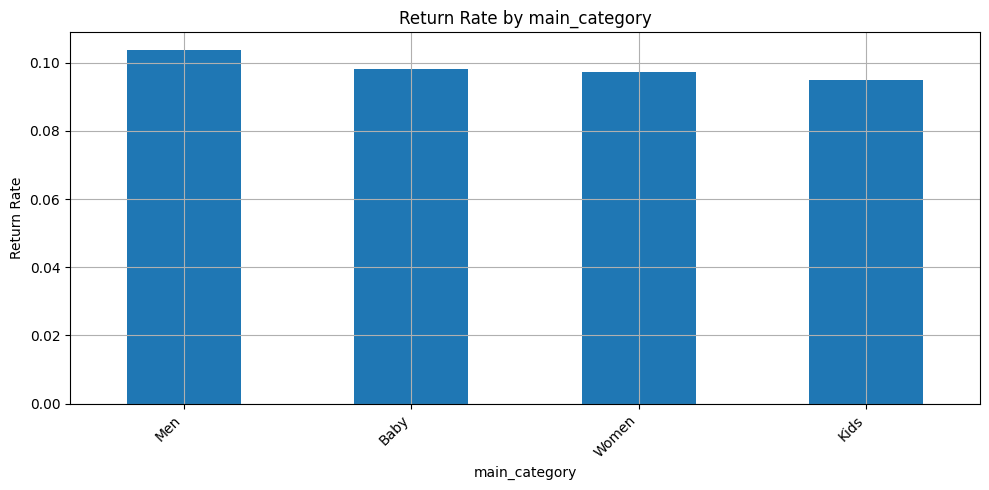

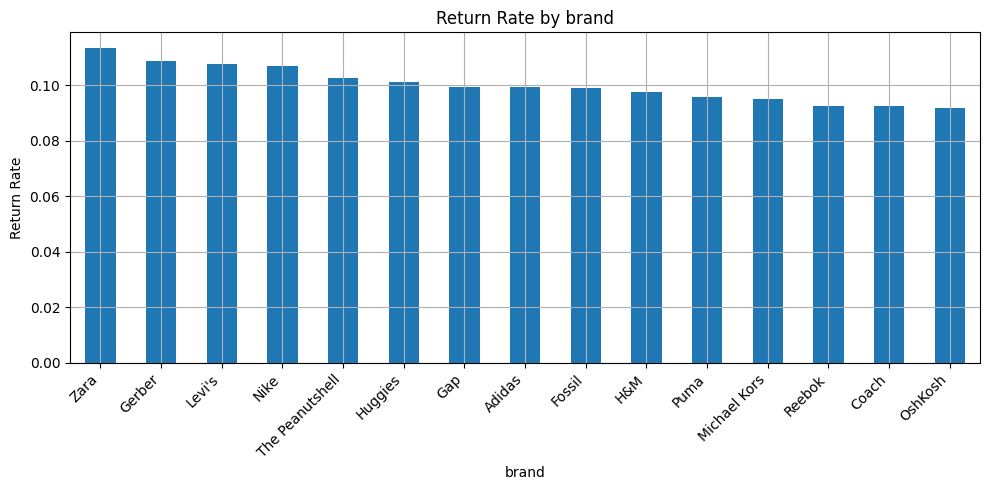

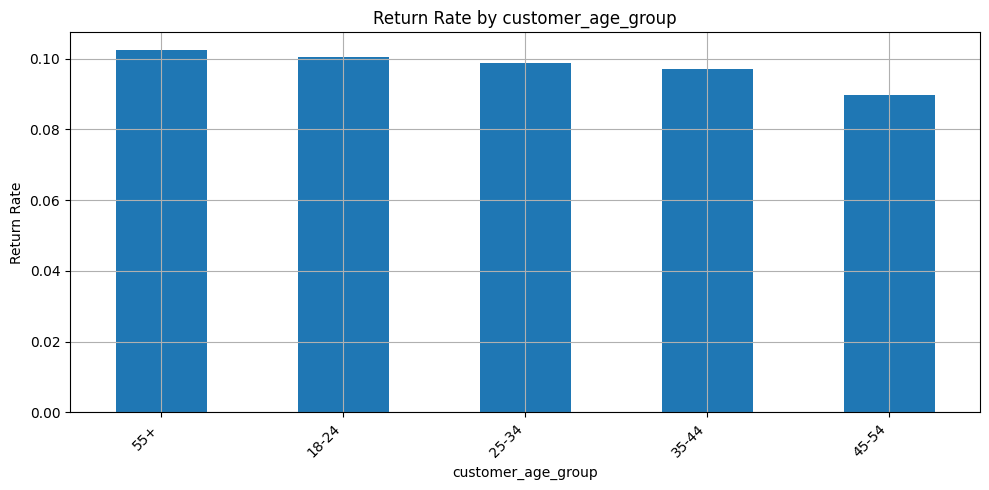

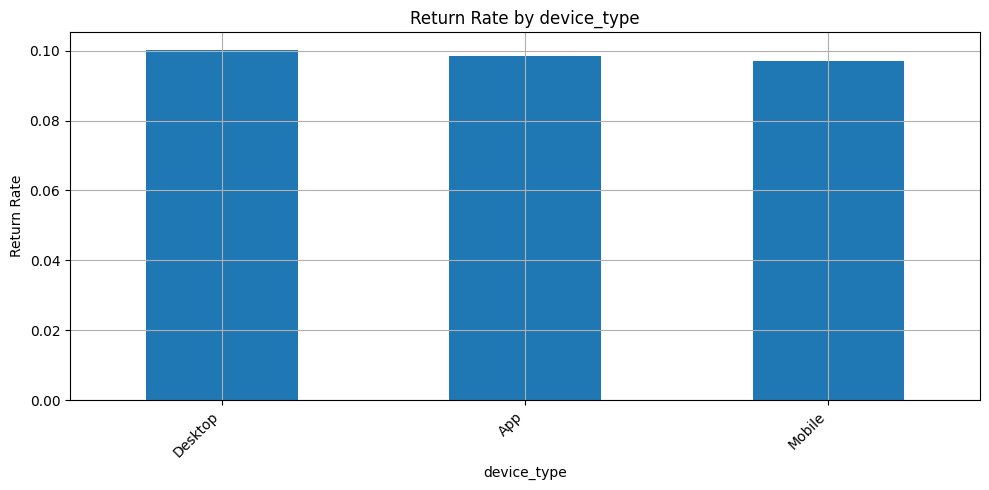

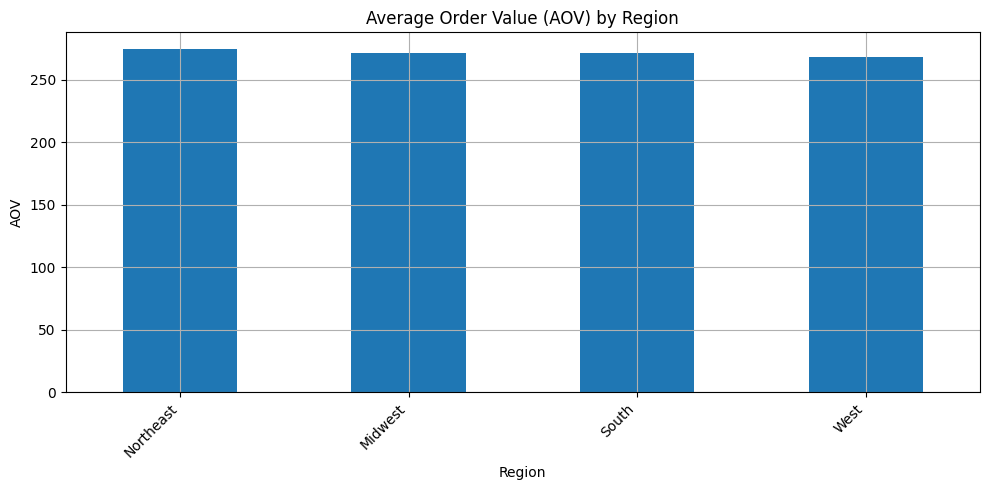

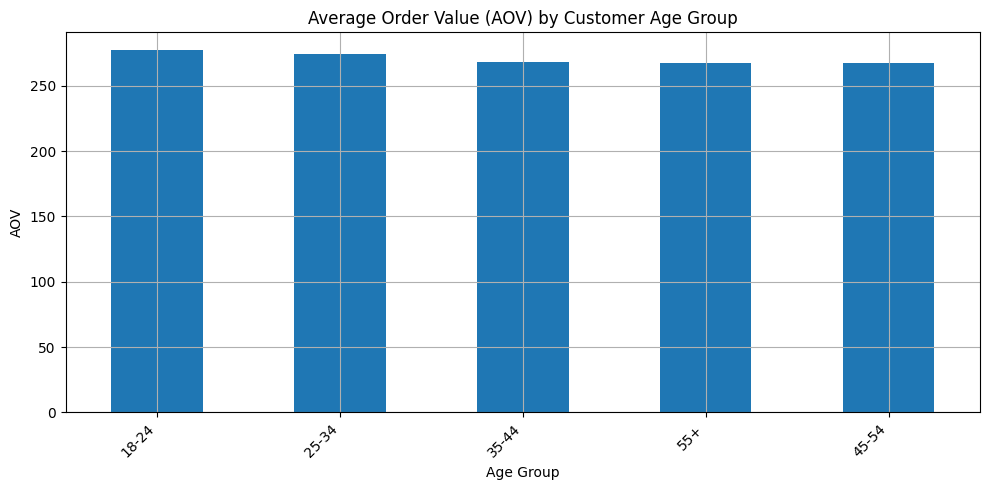

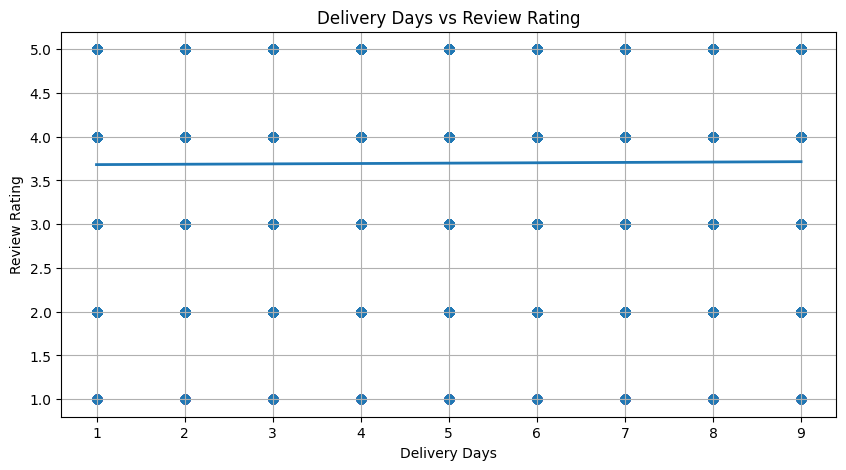

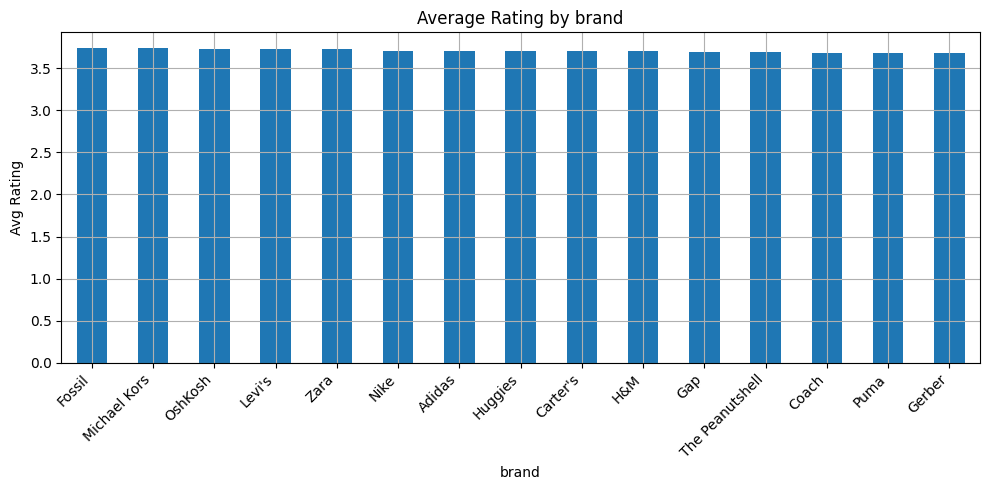

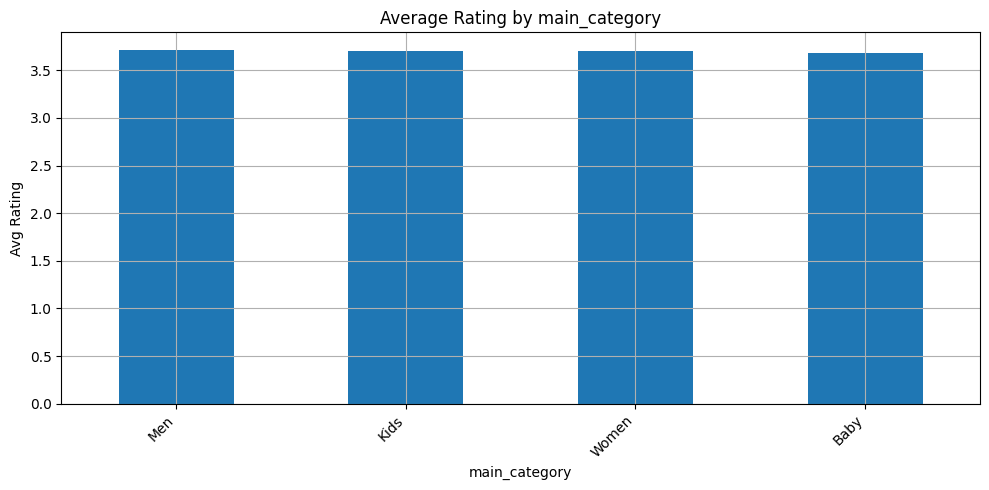

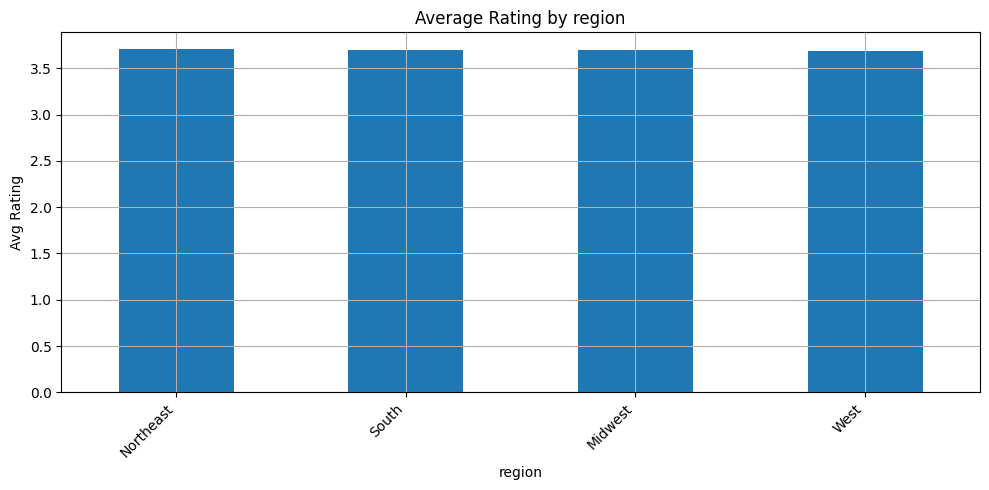

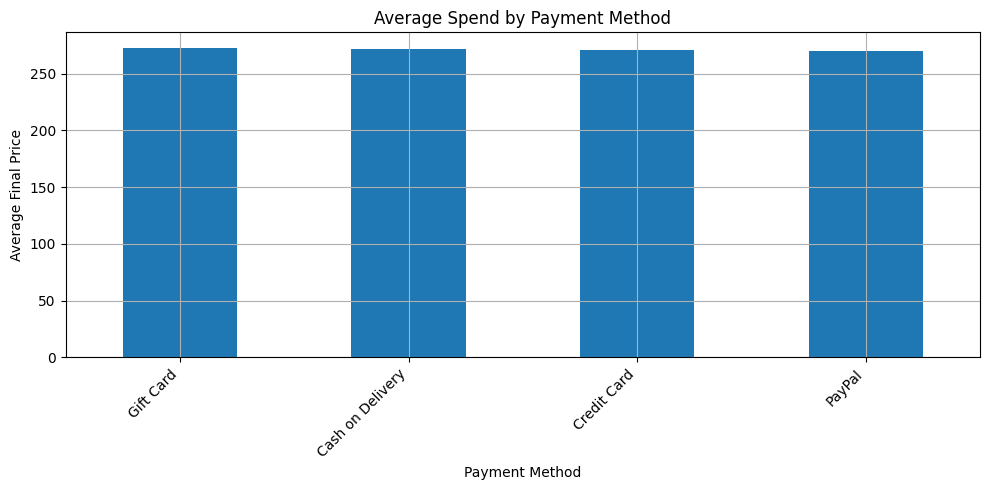

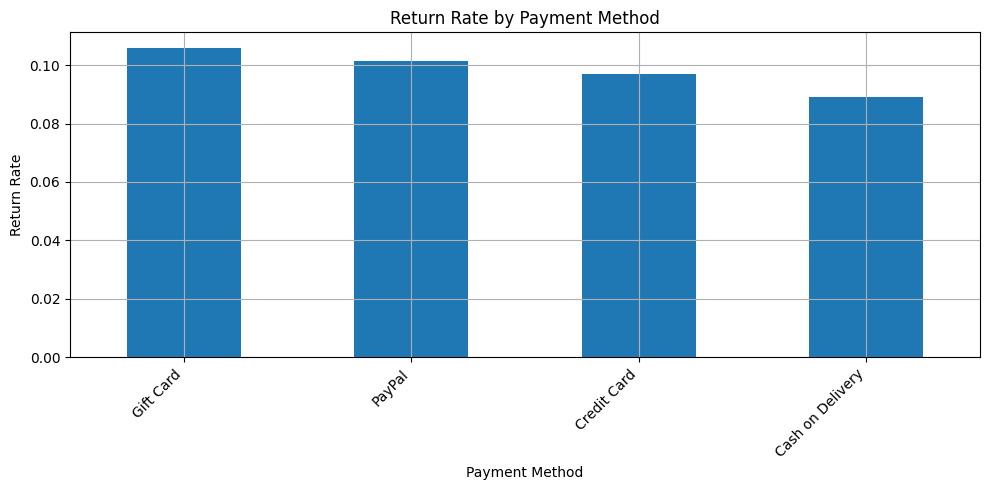

In [ ]:

# Sales Performance — Revenue over time (monthly trend)
if {"order_month","final_price"}.issubset(df.columns):
    rev_month = df.groupby("order_month")["final_price"].sum().sort_index()
    plt.figure()
    plt.plot(rev_month.index, rev_month.values, marker="o")
    plt.title("Monthly Revenue Trend")
    plt.xlabel("Month")
    plt.ylabel("Revenue (sum of final_price)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Which categories/brands drive most revenue?
for c in ["main_category","brand"]:
    if {c, "final_price"}.issubset(df.columns):
        top_rev = df.groupby(c)["final_price"].sum().sort_values(ascending=False).head(15)
        plt.figure()
        top_rev.plot(kind="bar")
        plt.title(f"Top {c} by Revenue")
        plt.xlabel(c)
        plt.ylabel("Revenue")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Price vs quantity — scatter with simple linear fit (numpy polyfit)
if {"price","quantity"}.issubset(df.columns):
    x = df["price"].astype(float)
    y = df["quantity"].astype(float)
    mask = x.notna() & y.notna()
    x1, y1 = x[mask], y[mask]
    plt.figure()
    plt.scatter(x1, y1, alpha=0.3)
    if len(x1) > 2:
        m, b = np.polyfit(x1, y1, 1)
        xs = np.linspace(x1.min(), x1.max(), 100)
        plt.plot(xs, m*xs + b, linewidth=2)
    plt.title("Price vs Quantity Sold")
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.show()
    print("Takeaway: Negative slope suggests higher prices may reduce quantity (verify with data).")

# Discount effectiveness — discount_percent vs quantity / revenue
if {"discount_percent","quantity"}.issubset(df.columns):
    x = df["discount_percent"]
    y = df["quantity"]
    msk = x.notna() & y.notna()
    plt.figure()
    plt.scatter(x[msk], y[msk], alpha=0.3)
    if msk.sum() > 2:
        m, b = np.polyfit(x[msk], y[msk], 1)
        xs = np.linspace(x[msk].min(), x[msk].max(), 100)
        plt.plot(xs, m*xs + b, linewidth=2)
    plt.title("Discount % vs Quantity Sold")
    plt.xlabel("Discount Percent")
    plt.ylabel("Quantity")
    plt.show()

if {"discount_percent","final_price"}.issubset(df.columns):
    x = df["discount_percent"]
    y = df["final_price"]
    msk = x.notna() & y.notna()
    plt.figure()
    plt.scatter(x[msk], y[msk], alpha=0.2)
    plt.title("Discount % vs Revenue (per line item)")
    plt.xlabel("Discount Percent")
    plt.ylabel("Final Price")
    plt.show()

# Returns Analysis — return rate by category, brand, age group, device
for c in ["main_category","brand","customer_age_group","device_type"]:
    if {c,"is_returned"}.issubset(df.columns):
        rr = df.groupby(c)["is_returned"].mean().sort_values(ascending=False).head(15)
        plt.figure()
        rr.plot(kind="bar")
        plt.title(f"Return Rate by {c}")
        plt.xlabel(c)
        plt.ylabel("Return Rate")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Customer Behavior — AOV by region / age group
if {"order_id","final_price","region"}.issubset(df.columns):
    aov_region = df.groupby(["region","order_id"])["final_price"].sum().groupby("region").mean().sort_values(ascending=False)
    plt.figure()
    aov_region.plot(kind="bar")
    plt.title("Average Order Value (AOV) by Region")
    plt.xlabel("Region")
    plt.ylabel("AOV")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

if {"order_id","final_price","customer_age_group"}.issubset(df.columns):
    aov_age = df.groupby(["customer_age_group","order_id"])["final_price"].sum().groupby("customer_age_group").mean().sort_values(ascending=False)
    plt.figure()
    aov_age.plot(kind="bar")
    plt.title("Average Order Value (AOV) by Customer Age Group")
    plt.xlabel("Age Group")
    plt.ylabel("AOV")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Delivery performance — delivery_days vs rating
if {"delivery_days","review_rating"}.issubset(df.columns):
    mask = df["delivery_days"].notna() & df["review_rating"].notna()
    plt.figure()
    plt.scatter(df.loc[mask, "delivery_days"], df.loc[mask, "review_rating"], alpha=0.3)
    m, b = np.polyfit(df.loc[mask, "delivery_days"], df.loc[mask, "review_rating"], 1) if mask.sum() > 2 else (None, None)
    if m is not None:
        xs = np.linspace(df.loc[mask, "delivery_days"].min(), df.loc[mask, "delivery_days"].max(), 100)
        plt.plot(xs, m*xs + b, linewidth=2)
    plt.title("Delivery Days vs Review Rating")
    plt.xlabel("Delivery Days")
    plt.ylabel("Review Rating")
    plt.show()

# Rating signal — average rating by brand/category/region
for c in ["brand","main_category","region"]:
    if {c,"review_rating"}.issubset(df.columns):
        avg_rating = df.groupby(c)["review_rating"].mean().sort_values(ascending=False).head(15)
        plt.figure()
        avg_rating.plot(kind="bar")
        plt.title(f"Average Rating by {c}")
        plt.xlabel(c)
        plt.ylabel("Avg Rating")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Payment method insights — spend & return likelihood
if {"payment_method","final_price"}.issubset(df.columns):
    spend_pm = df.groupby("payment_method")["final_price"].mean().sort_values(ascending=False)
    plt.figure()
    spend_pm.plot(kind="bar")
    plt.title("Average Spend by Payment Method")
    plt.xlabel("Payment Method")
    plt.ylabel("Average Final Price")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

if {"payment_method","is_returned"}.issubset(df.columns):
    rr_pm = df.groupby("payment_method")["is_returned"].mean().sort_values(ascending=False)
    plt.figure()
    rr_pm.plot(kind="bar")
    plt.title("Return Rate by Payment Method")
    plt.xlabel("Payment Method")
    plt.ylabel("Return Rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### Correlation Heatmap (numeric features)

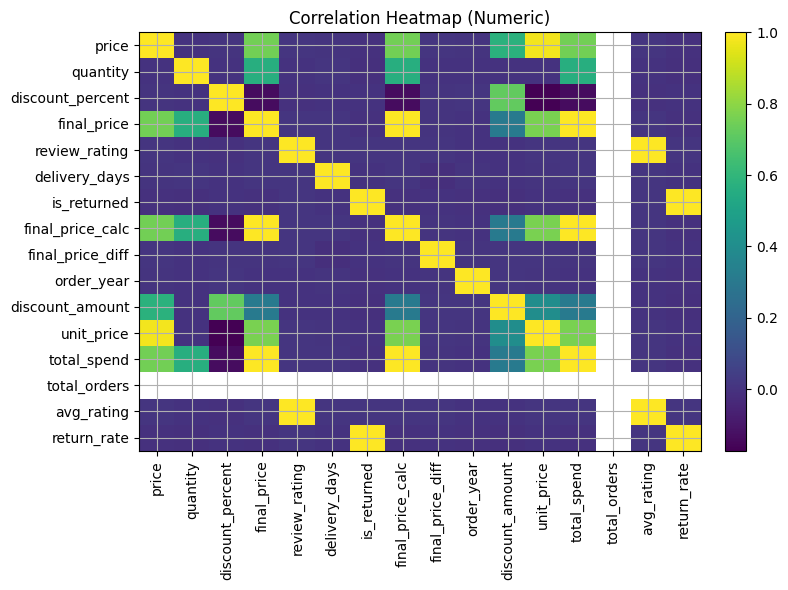

In [ ]:

num_df = df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
im = plt.imshow(corr, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numeric)")
plt.tight_layout()
plt.show()
